# Site selection analysis: Boston gyms

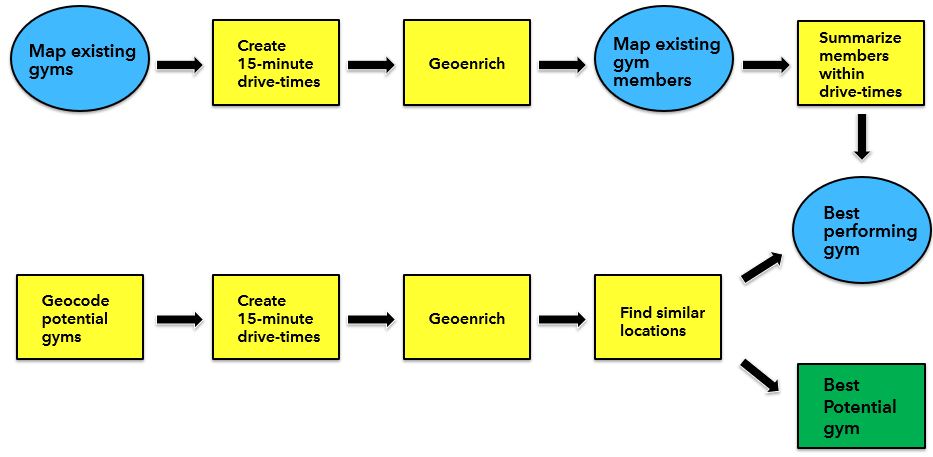

In [2]:
# import non-ArcGIS packages

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns

from IPython.display import HTML

# Get Data
This section utilizes the `gis` module to:
- Create a GIS connection
- Get feature services with data for existing gym locations and gym members

In [3]:
# Create a GIS connection
from arcgis.gis import GIS

username = "your_username"
gis = GIS("https://www.arcgis.com", username)

Enter password: ········


Here are the public links to the gyms and gym members feature layers.
 
Gyms - https://services.arcgis.com/SgB3dZDkkUxpEHxu/arcgis/rest/services/Boston_Gyms/FeatureServer    
Gym members - https://services.arcgis.com/SgB3dZDkkUxpEHxu/arcgis/rest/services/Boston_Members/FeatureServer

<Item title:"Boston_Gyms" type:Feature Layer Collection owner:nich7905>
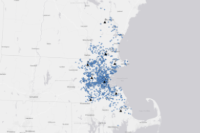

In [4]:
# Item Added From Toolbar
# Title: Boston_Gyms | Type: Feature Service
gyms = gis.content.get("43d123ca439c49168571308b9b3d8cf5")
gyms

<Item title:"Boston_Members" type:Feature Layer Collection owner:nich7905>
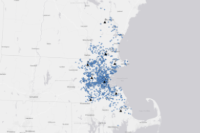

In [5]:
# search for the gym members layer
members = gis.content.get('b6665d54f7c344a39ffaa1b8d90e1240')
members

In [6]:
# map it out
m1 = gis.map('Boston', 7)
m1.basemap = 'gray-vector'
m1

MapView(layout=Layout(height='400px', width='100%'))

In [7]:
# add the gyms
m1.add_layer(gyms)

In [8]:
# add the gym members
m1.add_layer(members.layers[0])

# Create 15 minute drive-time polygons
We will import the `create_drive_time_areas()` method from use_proximity toolset in the features module. This method uses the network analysis service configured with your org.

In [9]:
# import necessary module: features.use_proximity
from arcgis.features.use_proximity import create_drive_time_areas

In [10]:
# create 15-minute drive-times
gym_dt_15 = create_drive_time_areas(input_layer=gyms, break_values=[15],output_name='gym_drivetimes_15', travel_direction='TowardsFacility')
gym_dt_15

<Item title:"gym_drivetimes_15" type:Feature Layer Collection owner:maggarwal_geosaurus>

In [11]:
# map out the 15-minute drive-times
m3 = gis.map('Boston', 7)
m3.basemap = 'gray-vector'
m3.add_layer(gyms)
m3.add_layer(gym_dt_15)
m3

MapView(layout=Layout(height='400px', width='100%'))

# Enrich drive time areas
Here we will use the:
- `data_collections` property of a `Country` object from `geoenrichment` module to identify socio-economic, lifestyle and exercise variables to enrich our data
- `enrich_layer()` method from `features` module to enrich the drive time areas

## Identify features to enrich

In [12]:
# # import necessary modules: geoenrichment
from arcgis.geoenrichment import Country

In [13]:
# display the various data topics available for geoenrichment for USA in the Esri database
usa = Country.get('US')
usa

<Country name:United States>

In [14]:
# see the available USA data as a pandas dataframe
usa_data_df = usa.data_collections
usa_data_df

,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
1yearincrements,1yearincrements.AGE0_CY,2020 Population Age <1,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE1_CY,2020 Population Age 1,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE2_CY,2020 Population Age 2,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE3_CY,2020 Population Age 3,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE4_CY,2020 Population Age 4,2020 Age: 1 Year Increments (Esri),2020
...,...,...,...,...
yearmovedin,yearmovedin.MOEMEDYRMV,2019 Median Year Householder Moved In MOE (ACS...,2015-2019 Year Householder Moved In (ACS),2015-2019
yearmovedin,yearmovedin.RELMEDYRMV,2019 Median Year Householder Moved In REL (ACS...,2015-2019 Year Householder Moved In (ACS),2015-2019
yearmovedin,yearmovedin.ACSOWNER,2019 Owner Households (ACS 5-Yr),2015-2019 Key Demographic Indicators (ACS),2015-2019


In [15]:
# search for certain strings in the 'alias' field
gym_vars = usa_data_df[usa_data_df['alias'].str.contains('Median Household Income|1D|2B|Exercise')]

# get the number of variables returned
print(len(gym_vars))

# look at the table of returned variables
gym_vars

52


,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
Demographic_and_Income_Comparison_Profile_rep,Demographic_and_Income_Comparison_Profile_rep....,Trends: 2015 - 2020 Annual Rate: Median Househ...,NaN,NaN
Demographic_and_Income_Profile_rep,Demographic_and_Income_Profile_rep.INCRATE,Trends: 2010 - 2015 Annual Rate: Median Househ...,NaN,NaN
Demographic_and_Income_Profile_rep,Demographic_and_Income_Profile_rep.INCRATE_S,Trends: 2015 - 2020 Annual Rate: Median Househ...,NaN,NaN
Health,Health.MEDHINC_CY,2020 Median Household Income,2020 Income (Esri),2020
HealthPersonalCare,HealthPersonalCare.MP14001a_B,2020 Exercise at home 2+ times per week,2020 Health (Market Potential),2020
HealthPersonalCare,HealthPersonalCare.MP14001a_I,2020 Index: Exercise at home 2+ times per week,2020 Health (Market Potential),2020
HealthPersonalCare,HealthPersonalCare.MP14002a_B,2020 Exercise at club 2+ times per week,2020 Health (Market Potential),2020
HealthPersonalCare,HealthPersonalCare.MP14002a_I,2020 Index: Exercise at club 2+ times per week,2020 Health (Market Potential),2020
HealthPersonalCare,HealthPersonalCare.MP14003a_B,2020 Exercise at other facility 2+ times/wk,2020 Health (Market Potential),2020


Let's use the following features for enrichment:    

| Name | Description |
|-|-|
| MEDHINC_CY     | 2020 Median Household Income |
| MP14002a_I     | 2020 Index: Exercise at club 2+ times per week' |
| TADULT04     | 2020 Pop 18+ in Tapestry Seg 1D' |
| TADULT07 | 2020 Pop 18+ in Tapestry Seg 2B |

In [16]:
gym_var_names = ['Health.MEDHINC_CY', 'HealthPersonalCare.MP14002a_I',
                'tapestryadultsNEW.TADULT04','tapestryadultsNEW.TADULT07']

## Enrich the drive time areas

In [17]:
# import necessary modules: features.enrich_layer
from arcgis.features.enrich_data import enrich_layer

In [18]:
gym_dt_15_enrich = enrich_layer(input_layer=gym_dt_15, 
                                analysis_variables=gym_var_names, 
                                output_name='gym_dt_15_enrich')
gym_dt_15_enrich

<Item title:"gym_dt_15_enrich" type:Feature Layer Collection owner:maggarwal_geosaurus>

In [19]:
# convert the enriched drive-times to spatial dataframe
gym_dt_15_enrich_df = gym_dt_15_enrich.layers[0].query().sdf

# look at the rows and columns
print(gym_dt_15_enrich_df.shape)

# check out the first few rows
gym_dt_15_enrich_df.head()

(9, 25)


,OBJECTID,Name,FromBreak,ToBreak,FacilityOID,Name_1,STORE_NUM,POINT_X,POINT_Y,Breaks,...,ENRICH_FID,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,MEDHINC_CY,MP14002a_I,TADULT04,TADULT07,SHAPE
0,1,Location 1 : 0 - 15,0,15,1,Location 1,1,260646.359305,849426.718924,None,...,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,85262,117,5751,7569,"{""rings"": [[[254294.245700002, 861408.44150000..."
1,2,Location 8 : 0 - 15,0,15,8,Location 8,8,203411.620086,929203.037213,None,...,2,BlockApportionment:US.BlockGroups,2.191,2.576,1,103012,136,10966,8189,"{""rings"": [[[203295.694799997, 942797.66169999..."
2,3,Location 4 : 0 - 15,0,15,4,Location 4,4,208604.802433,868336.315022,None,...,3,BlockApportionment:US.BlockGroups,2.191,2.576,1,105723,138,11196,25087,"{""rings"": [[[195813.776299998, 886145.34849999..."
3,4,Location 9 : 0 - 15,0,15,9,Location 9,9,252774.873831,879401.332448,None,...,4,BlockApportionment:US.BlockGroups,2.191,2.576,1,96698,134,13175,21137,"{""rings"": [[[250169.984300002, 889241.4408], [..."
4,5,Location 5 : 0 - 15,0,15,5,Location 5,5,210536.458525,906299.556125,None,...,5,BlockApportionment:US.BlockGroups,2.191,2.576,1,196837,165,195,423,"{""rings"": [[[212082.966600001, 912796.10110000..."


In [20]:
# Rename columns
cols_to_rename = {'MEDHINC_CY': '2020 Median Household Income',
                  'MP14002a_I': '2020 Index: Exercise at club 2+ times per week',
                  'TADULT04': '2020 Pop 18+ in Tapestry Seg 1D',
                  'TADULT07': '2020 Pop 18+ in Tapestry Seg 2B'}

# rename original field names with alias names to make things much easier
gym_dt_15_enrich_df.rename(columns=cols_to_rename, inplace=True)
gym_dt_15_enrich_df.head()

,OBJECTID,Name,FromBreak,ToBreak,FacilityOID,Name_1,STORE_NUM,POINT_X,POINT_Y,Breaks,...,ENRICH_FID,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,2020 Median Household Income,2020 Index: Exercise at club 2+ times per week,2020 Pop 18+ in Tapestry Seg 1D,2020 Pop 18+ in Tapestry Seg 2B,SHAPE
0,1,Location 1 : 0 - 15,0,15,1,Location 1,1,260646.359305,849426.718924,None,...,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,85262,117,5751,7569,"{""rings"": [[[254294.245700002, 861408.44150000..."
1,2,Location 8 : 0 - 15,0,15,8,Location 8,8,203411.620086,929203.037213,None,...,2,BlockApportionment:US.BlockGroups,2.191,2.576,1,103012,136,10966,8189,"{""rings"": [[[203295.694799997, 942797.66169999..."
2,3,Location 4 : 0 - 15,0,15,4,Location 4,4,208604.802433,868336.315022,None,...,3,BlockApportionment:US.BlockGroups,2.191,2.576,1,105723,138,11196,25087,"{""rings"": [[[195813.776299998, 886145.34849999..."
3,4,Location 9 : 0 - 15,0,15,9,Location 9,9,252774.873831,879401.332448,None,...,4,BlockApportionment:US.BlockGroups,2.191,2.576,1,96698,134,13175,21137,"{""rings"": [[[250169.984300002, 889241.4408], [..."
4,5,Location 5 : 0 - 15,0,15,5,Location 5,5,210536.458525,906299.556125,None,...,5,BlockApportionment:US.BlockGroups,2.191,2.576,1,196837,165,195,423,"{""rings"": [[[212082.966600001, 912796.10110000..."


# Summarize members with-in drive times
We will use the `summarize_within()` method from feature analysis toolset of the `features` module to summarize gym members within 15 min drive-times created earlier. We will summarize by the average dollar amount spent field.

In [21]:
# get the layer from the gym members feature data collection
gym_members_lyr = members.layers[0]

In [22]:
from arcgis.features.analysis import summarize_within

# summarize within (gym members within existing store locations)
gyms_summary = summarize_within(sum_within_layer=gym_dt_15, 
                                summary_layer=gym_members_lyr, 
                                summary_fields=['Dollars MEAN'], 
                                output_name='gyms_summary')
gyms_summary

<Item title:"gyms_summary" type:Feature Layer Collection owner:maggarwal_geosaurus>

In [23]:
# convert the enriched drive-times to spatial dataframe
gyms_summary_sdf = gyms_summary.layers[0].query().sdf
gyms_summary_sdf

# keep only necessary columns
gyms_summary_sdf_final = gyms_summary_sdf[['STORE_NUM','Point_Count', 'POINT_X', 'POINT_Y', 'MEAN_Dollars', 'SHAPE']]

# look at the rows and columns
print(gyms_summary_sdf_final.shape)

# sort based on the total dollars made per gym
gyms_summary_sdf_final.sort_values('MEAN_Dollars', ascending=False)

(9, 6)


,STORE_NUM,Point_Count,POINT_X,POINT_Y,MEAN_Dollars,SHAPE
3,9,43,252774.873831,8.794013e+05,884.899302,"{""rings"": [[[250169.984300002, 889241.4408], [..."
1,8,56,203411.620086,9.292030e+05,833.757679,"{""rings"": [[[203295.694799997, 942797.66169999..."
4,5,24,210536.458525,9.062996e+05,827.272500,"{""rings"": [[[212082.966600001, 912796.10110000..."
7,2,31,250355.862616,9.306934e+05,814.673871,"{""rings"": [[[248624.935000002, 940820.5605], [..."
5,7,372,232735.393579,8.994457e+05,731.663038,"{""rings"": [[[235487.485200003, 904867.7601], [..."
2,4,34,208604.802433,8.683363e+05,651.096176,"{""rings"": [[[195813.776299998, 886145.34849999..."
6,3,34,234848.780179,9.473475e+05,593.846471,"{""rings"": [[[238738.695500001, 958672.0836], [..."
0,1,12,260646.359305,8.494267e+05,539.510000,"{""rings"": [[[254294.245700002, 861408.44150000..."
8,6,5,233178.484600,1.002825e+06,191.764000,"{""rings"": [[[235989.212700002, 1011006.9408], ..."


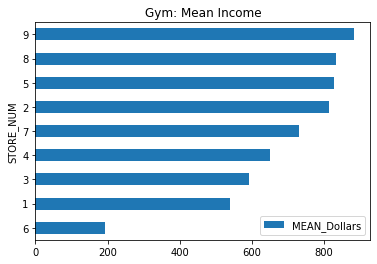

In [24]:
# bar chart

ax = gyms_summary_sdf_final.sort_values('MEAN_Dollars', ascending=True)\
                            .plot.barh(x='STORE_NUM', y='MEAN_Dollars')
ax.set_title('Gym: Mean Income');

> From the plot, we can see that gym #9 has the highest mean income. We will identify this as the best performing gym location.

In [25]:
# get a subset of the columns
gym_dt_15_enrich_df_final = gym_dt_15_enrich_df[['STORE_NUM','2020 Median Household Income', '2020 Index: Exercise at club 2+ times per week',
 '2020 Pop 18+ in Tapestry Seg 1D', '2020 Pop 18+ in Tapestry Seg 2B', 'SHAPE' ]]
gym_dt_15_enrich_df_final

,STORE_NUM,2020 Median Household Income,2020 Index: Exercise at club 2+ times per week,2020 Pop 18+ in Tapestry Seg 1D,2020 Pop 18+ in Tapestry Seg 2B,SHAPE
0,1,85262,117,5751,7569,"{""rings"": [[[254294.245700002, 861408.44150000..."
1,8,103012,136,10966,8189,"{""rings"": [[[203295.694799997, 942797.66169999..."
2,4,105723,138,11196,25087,"{""rings"": [[[195813.776299998, 886145.34849999..."
3,9,96698,134,13175,21137,"{""rings"": [[[250169.984300002, 889241.4408], [..."
4,5,196837,165,195,423,"{""rings"": [[[212082.966600001, 912796.10110000..."
5,7,80035,147,0,0,"{""rings"": [[[235487.485200003, 904867.7601], [..."
6,3,75895,109,11630,17975,"{""rings"": [[[238738.695500001, 958672.0836], [..."
7,2,93661,141,9687,10912,"{""rings"": [[[248624.935000002, 940820.5605], [..."
8,6,65399,90,0,0,"{""rings"": [[[235989.212700002, 1011006.9408], ..."


# Get potential gym locations

Here we will:
- Read the potential gym location data and geocode
- Create 15 minute drive-time around these locations
- Enrich drive-times with the same features as earlier

In [26]:
# Read data
dataset = '/arcgis/home/Potential_gyms2.csv'

In [27]:
# geocode the potential gym locations
potential_gyms = pd.read_csv(dataset)
potential_gyms

,CLUSTER_ID,Address,City,County,State,ZIP,ZIP4,Country
0,1,West Park Dr,Portsmouth,Rockingham County,New Hampshire,3801,NaN,USA
1,2,176 South Rd,Londonderry,Rockingham County,New Hampshire,3053,3702.0,USA
2,3,270 Eliot Street,Natick,Middlesex County,Massachusetts,1760,5513.0,USA
3,4,40 Main Street,Stoneham,Middlesex County,Massachusetts,2180,3304.0,USA


In [28]:
# concatenate Address, City, State, ZIP into one field for geocoding purposes
potential_gyms['Address_full']=potential_gyms['Address'].astype(str)+', '+potential_gyms['City']+', '+potential_gyms['State']+ ' ' + '0' +potential_gyms['ZIP'].astype(str)
potential_gyms.head()

,CLUSTER_ID,Address,City,County,State,ZIP,ZIP4,Country,Address_full
0,1,West Park Dr,Portsmouth,Rockingham County,New Hampshire,3801,NaN,USA,"West Park Dr, Portsmouth, New Hampshire 03801"
1,2,176 South Rd,Londonderry,Rockingham County,New Hampshire,3053,3702.0,USA,"176 South Rd, Londonderry, New Hampshire 03053"
2,3,270 Eliot Street,Natick,Middlesex County,Massachusetts,1760,5513.0,USA,"270 Eliot Street, Natick, Massachusetts 01760"
3,4,40 Main Street,Stoneham,Middlesex County,Massachusetts,2180,3304.0,USA,"40 Main Street, Stoneham, Massachusetts 02180"


## Geocode
The `from_df()` method geocodes the dataset using the geocoder configured with your organization and returns a spatially enabled dataframe.

In [29]:
# add the potential gyms csv as an item to ArcGIS Online - creates CSV item in the portal
from arcgis import GeoAccessor, GeoSeriesAccessor

potential_gyms_sdf = pd.DataFrame.spatial.from_df(potential_gyms, 
                                                  address_column="Address_full")
potential_gyms_sdf.head()

,CLUSTER_ID,Address,City,County,State,ZIP,ZIP4,Country,Address_full,SHAPE
0,1,West Park Dr,Portsmouth,Rockingham County,New Hampshire,3801,NaN,USA,"West Park Dr, Portsmouth, New Hampshire 03801","{""x"": -70.80674254299998, ""y"": 43.098914893000..."
1,2,176 South Rd,Londonderry,Rockingham County,New Hampshire,3053,3702.0,USA,"176 South Rd, Londonderry, New Hampshire 03053","{""x"": -71.33541592899996, ""y"": 42.854693016000..."
2,3,270 Eliot Street,Natick,Middlesex County,Massachusetts,1760,5513.0,USA,"270 Eliot Street, Natick, Massachusetts 01760","{""x"": -71.33824859299995, ""y"": 42.256844427000..."
3,4,40 Main Street,Stoneham,Middlesex County,Massachusetts,2180,3304.0,USA,"40 Main Street, Stoneham, Massachusetts 02180","{""x"": -71.10037009699994, ""y"": 42.499778384000..."


In [30]:
# convert spatial dataframe to feature collection so it is a "hosted layer" - creates layer in the portal
# https://developers.arcgis.com/python/guide/accessing-and-creating-content/

Boston_potential_gyms = gis.content.import_data(df=potential_gyms_sdf, title='Boston_potential_gyms')
Boston_potential_gyms

<Item title:"Boston_potential_gyms" type:Feature Layer Collection owner:maggarwal_geosaurus>

In [31]:
# create a map to plot the all of the data so far
m4 = gis.map('Boston', 7)
m4.basemap = 'gray-vector'
m4.add_layer(gyms)
m4.add_layer(gym_dt_15)
m4

MapView(layout=Layout(height='400px', width='100%'))

> The plot shows existing gym locations, their drive-times and potential gym locations.

In [32]:
# add the potential gyms
m4.add_layer(Boston_potential_gyms)

## Create 15 minute drive times and enrich potential locations
Let's create 15 minute drive times around potential gym locations and enrich with the same socio-economic, lifestyle and exercise variables.

In [33]:
# 15-minute drive-times on the potential gym locations
potential_dt_15 = create_drive_time_areas(input_layer=Boston_potential_gyms, 
                                          break_values=[15],
                                          output_name='potential_drivetimes_15',
                                          travel_direction='TowardsFacility')
potential_dt_15

<Item title:"potential_drivetimes_15" type:Feature Layer Collection owner:maggarwal_geosaurus>

In [34]:
# enrich the potential gym locations with the same demographic variables
potential_dt_15_enrich = enrich_layer(input_layer=potential_dt_15, 
                                      analysis_variables=gym_var_names, 
                                      output_name='potential_dt_15_enrich')
potential_dt_15_enrich

<Item title:"potential_dt_15_enrich" type:Feature Layer Collection owner:maggarwal_geosaurus>

In [35]:
# create a map to plot the all of the data so far
m5 = gis.map('Boston', 7)
m5.basemap = 'gray-vector'
m5.add_layer(gyms)
m5.add_layer(gym_dt_15)
m5.add_layer(Boston_potential_gyms)
m5.add_layer(potential_dt_15)
m5

MapView(layout=Layout(height='400px', width='100%'))

> The plot shows existing and potential gym location along with their enriched drive-times.

# Find best potential gym

Here we will:
- Use `find_existing_locations()` method to select features for best performing gym #9
- Use `find_similar_locations()` method from features module to create a similarity rank for potential gym locations using the best candidate gym location and socio-economic, lifestyle and exercise features chosen earlier

In [36]:
# get the layer from the original gyms 15-minute enriched drive-times
gym_dt_15_enrich_lyr = gym_dt_15_enrich.layers

# get the layer from the potential gyms 15-minute enriched drive-times
potential_dt_15_enrich_lyr = potential_dt_15_enrich.layers

## Subset features for best performing location (gym #9)
The `find_existing_locations()` selects features in the input layer that meet a query. We will select features for gym no# 9 and create a layer.

In [37]:
from arcgis.features.analysis import find_existing_locations

In [38]:
best_candidate = find_existing_locations(input_layers=[gym_dt_15_enrich], 
                                         expressions=[{"operator":"","layer":0,"where":"STORE_NUM = 9"}], 
                                         output_name= 'best_candidate_lyr')
best_candidate

<Item title:"best_candidate_lyr" type:Feature Layer Collection owner:maggarwal_geosaurus>

## Find a location similar to the best performing gym

`find_similar_locations()` method from `features` module can be used to create a similarity rank for potential gym locations using the best candidate gym location and socio-economic, lifestyle features chosen earlier.

In [39]:
# import necessary modules: analysis.fine_similar_locations
from arcgis.features.analysis import find_similar_locations

In [40]:
# similarity search
most_similar = find_similar_locations(input_layer=best_candidate, 
                                      search_layer=potential_dt_15_enrich, 
                                      analysis_fields=['MEDHINC_CY', 'MP14002a_I', 'TADULT04', 'TADULT07'], 
                                      output_name='find_similar')

In [41]:
# search for the content and add it to the map
most_similar_lyr = gis.content.search('title: find_similar, owner: maggarwal_geosaurus', outside_org=True)[0]

m6 = gis.map('Boston', 7)
m6.basemap = 'gray-vector'
m6.add_layer(gyms)
m6.add_layer(gym_dt_15)
m6.add_layer(Boston_potential_gyms)
m6.add_layer(most_similar_lyr)
m6.legend = True
m6

MapView(layout=Layout(height='400px', width='100%'), legend=True)

> The plot shows:    
    - Existing gym locations along with their enriched drive times    
    - Best performing gym location (in red)    
    - Potential gym locations colored by similarity rank    
    
The New Hampshire location is best potential location for a new gym.